In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import cv2
import string
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import pad_sequences, to_categorical, plot_model
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM, Embedding,add, Concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau

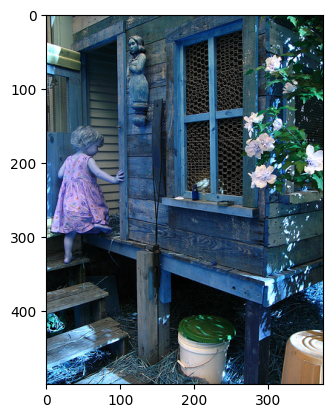

In [3]:
img = cv2.imread("/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg")
plt.imshow(img)

In [4]:
import re
def load_caption(text):
    mapping = {}
    for line in text.split('\n'):
        if len(line)<2:
            continue
        tokens = line.split(',')
        image_id , caption = tokens[0], tokens[1]
        #Remove extension from img id
        image_id = image_id.split('.')[0]
        if image_id not in mapping.keys():
            mapping[image_id] = list()
        mapping[image_id].append(caption)
    return mapping
def preprocess_caption(mapping):
    pattern = r'[^a-zA-Z\s]'
    for key,captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            ## removing any special characters
            clean_caption = re.sub(pattern, '', caption)
            ## removing consecutive spaces
            clean_caption = re.sub(r'\s+', ' ', clean_caption)
            caption = 'startseq '+ " ".join([word for word in clean_caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption
    
with open("/kaggle/input/flickr8k/captions.txt") as f1:
    next(f1)
    text = f1.read()
    f1.close()

mappings = load_caption(text)
preprocess_caption(mappings)


In [5]:
# with open('/kaggle/working/mappings.pkl', 'wb') as f1:
#     pickle.dump(mappings, f1)

In [5]:
mappings['1000268201_693b08cb0e']


['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [6]:
##Tokenizer
import tensorflow as tf
def create_tokenizer(mappings):    
    all_captions = []
    for values in mappings.values():
        for i in values:
            all_captions.append(i)
    ##Keras tokenizer gives the lower index value to the frequently repeating words and
    ##give highest value to the unique words/
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(all_captions)
    # print(tokenizer.word_index)
    vocab_size = (len(tokenizer.word_index)) + 1
    max_len = 0
    for caption in all_captions:
        l1 = len(caption.split())
        max_len = max(max_len, l1)
    return tokenizer, vocab_size, max_len
    

In [7]:
# with open('/kaggle/working/description.pkl', 'wb') as f1:
#     pickle.dump(all_captions, f1)

# Use keras VGG model to extract the feature of the image.

In [31]:
model = VGG16()
#since we use VGG16 only for feature extraction of an image, so eliminating last layer
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
##Extract features of the image
def feature_extraction(directory, model):
    features = {}
    for img_name in os.listdir(directory):
        img_path = directory+ '/' + img_name
        img = cv2.imread(img_path)
        try:
            img = cv2.resize(img, (224,224))
        except:
            break
        #converting into (1,224,224,3) as this is accepted by our VGG model
        img = img.reshape(1,img.shape[0],img.shape[1],img.shape[2])
        #Preprocess input using keras library that is used in VGG
        processed_img = preprocess_input(img)
        feature = model.predict(processed_img, verbose = 0)
        img_index = img_name.split('.')[0]
        features[img_index] = feature
    return features

    
BASE_DIR = "/kaggle/input/flickr8k/"
OUTPUT_DIR = "/kaggle/working/"    
image_directory = os.path.join(BASE_DIR,"Images")
# feature_dict = feature_extraction(image_directory, model) #This operation takes time, so we save our 
                                                          # feature_dict into pickle file

In [10]:
# with open(file_path, 'wb') as f:
#     pickle.dump(feature_dict, f)

In [7]:
with open('/kaggle/input/image-feature/features.pkl', 'rb') as f:
    feature_dict = pickle.load(f)

In [8]:
len(feature_dict.values())

8091

In [52]:
##checking what does texts_to_sequences do.
i=0
for key, captions in mappings.items():
        for caption in captions:
            ### convert the each words to the tokenize index
            seq = tokenizer.texts_to_sequences([caption])[0]
            print(f"Caption:  {caption}")
            print(f"Seq value: {seq}")
            for i in range(1, len(seq)):
                in_seq , out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=29)[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                print(f"in_seq: {in_seq}" )
                if i==6:
                    break
                i+=1
            if i ==2:
                break
            i+=1
        break

Caption:  startseq child in pink dress is climbing up set of stairs in an entry way endseq
Seq value: [1, 43, 3, 95, 174, 6, 120, 52, 397, 11, 353, 3, 27, 4830, 657, 2]
in_seq: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
in_seq: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  1 43]
in_seq: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  1 43  3]
in_seq: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  1 43  3 95]
in_seq: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   1  43   3  95 174]
in_seq: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   1  43   3  95 174   6]
Caption:  startseq girl going into wooden building endseq
Seq value: [1, 18, 316, 63, 193, 116, 2]
in_seq: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
in_seq: [ 0  0  0  0  0  0  0  0  0  0  0  0  0 

In [9]:
##We use batch size for progressive training because of memory issue.
def data_generator(tokenizer, max_len, mappings, feature_dict, vocab_size, batchsize):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key,captions in mappings.items():
            n += 1
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_len)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(feature_dict[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

# Test Train split

In [12]:
image_ids = list(mappings.keys())
split = int(0.9*len(image_ids))
train_ids = image_ids[:split]
test_ids = image_ids[split:]

In [13]:
##storing training data
X1_caption_train = {}
X2_feature_train = {}
for i in train_ids:
    X1_caption_train[i] = mappings[i]
    X2_feature_train[i] = feature_dict[i]

#storing testing data
X1_caption_test = {}
X2_feature_test = {}
for i in test_ids:
    X1_caption_test[i] = mappings[i]
    X2_feature_test[i] = feature_dict[i]

In [14]:
print(X2_feature_train['1000268201_693b08cb0e'].shape)

(1, 4096)


# Model Creation

In [11]:
def create_model(vocab_size, max_len):
    input_image = Input(shape=(4096,), name = 'image')
    f1 = Dropout(0.5)(input_image)
    f_image = Dense(256,activation='relu',name="ImageFeature")(f1)
    
    ##Language model
    inputs_caption = Input(shape=(max_len,), name = 'text')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs_caption)
    se2 = Dropout(0.5)(se1)
    f_caption = LSTM(256, name="CaptionFeature")(se2)
    
    ##Decoder_model
    decoder_model_1 = add([f_image, f_caption])
    decoder_model_2 = Dense(256,activation = 'relu')(decoder_model_1)
    outputs = Dense(vocab_size, activation='softmax')(decoder_model_2)
    
    model = Model(inputs=[input_image, inputs_caption], outputs=outputs)
    
    print("Model created successfully")
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

# Training the model

Model created successfully


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 31)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image (InputLayer)  │ (None, 4096)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 31, 256)   │  2,103,296 │ text[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4096)      │          0 │ image[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 31, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 31)        │          0 │ text[0][0]        │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ImageFeature        │ (None, 256)       │  1,048,832 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CaptionFeature      │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│ (LSTM)              │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ ImageFeature[0][… │
│                     │                   │            │ CaptionFeature[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 8216)      │  2,111,512 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,854,744 (22.33 MB)

 Trainable params: 5,854,744 (22.33 MB)

 Non-trainable params: 0 (0.00 B)

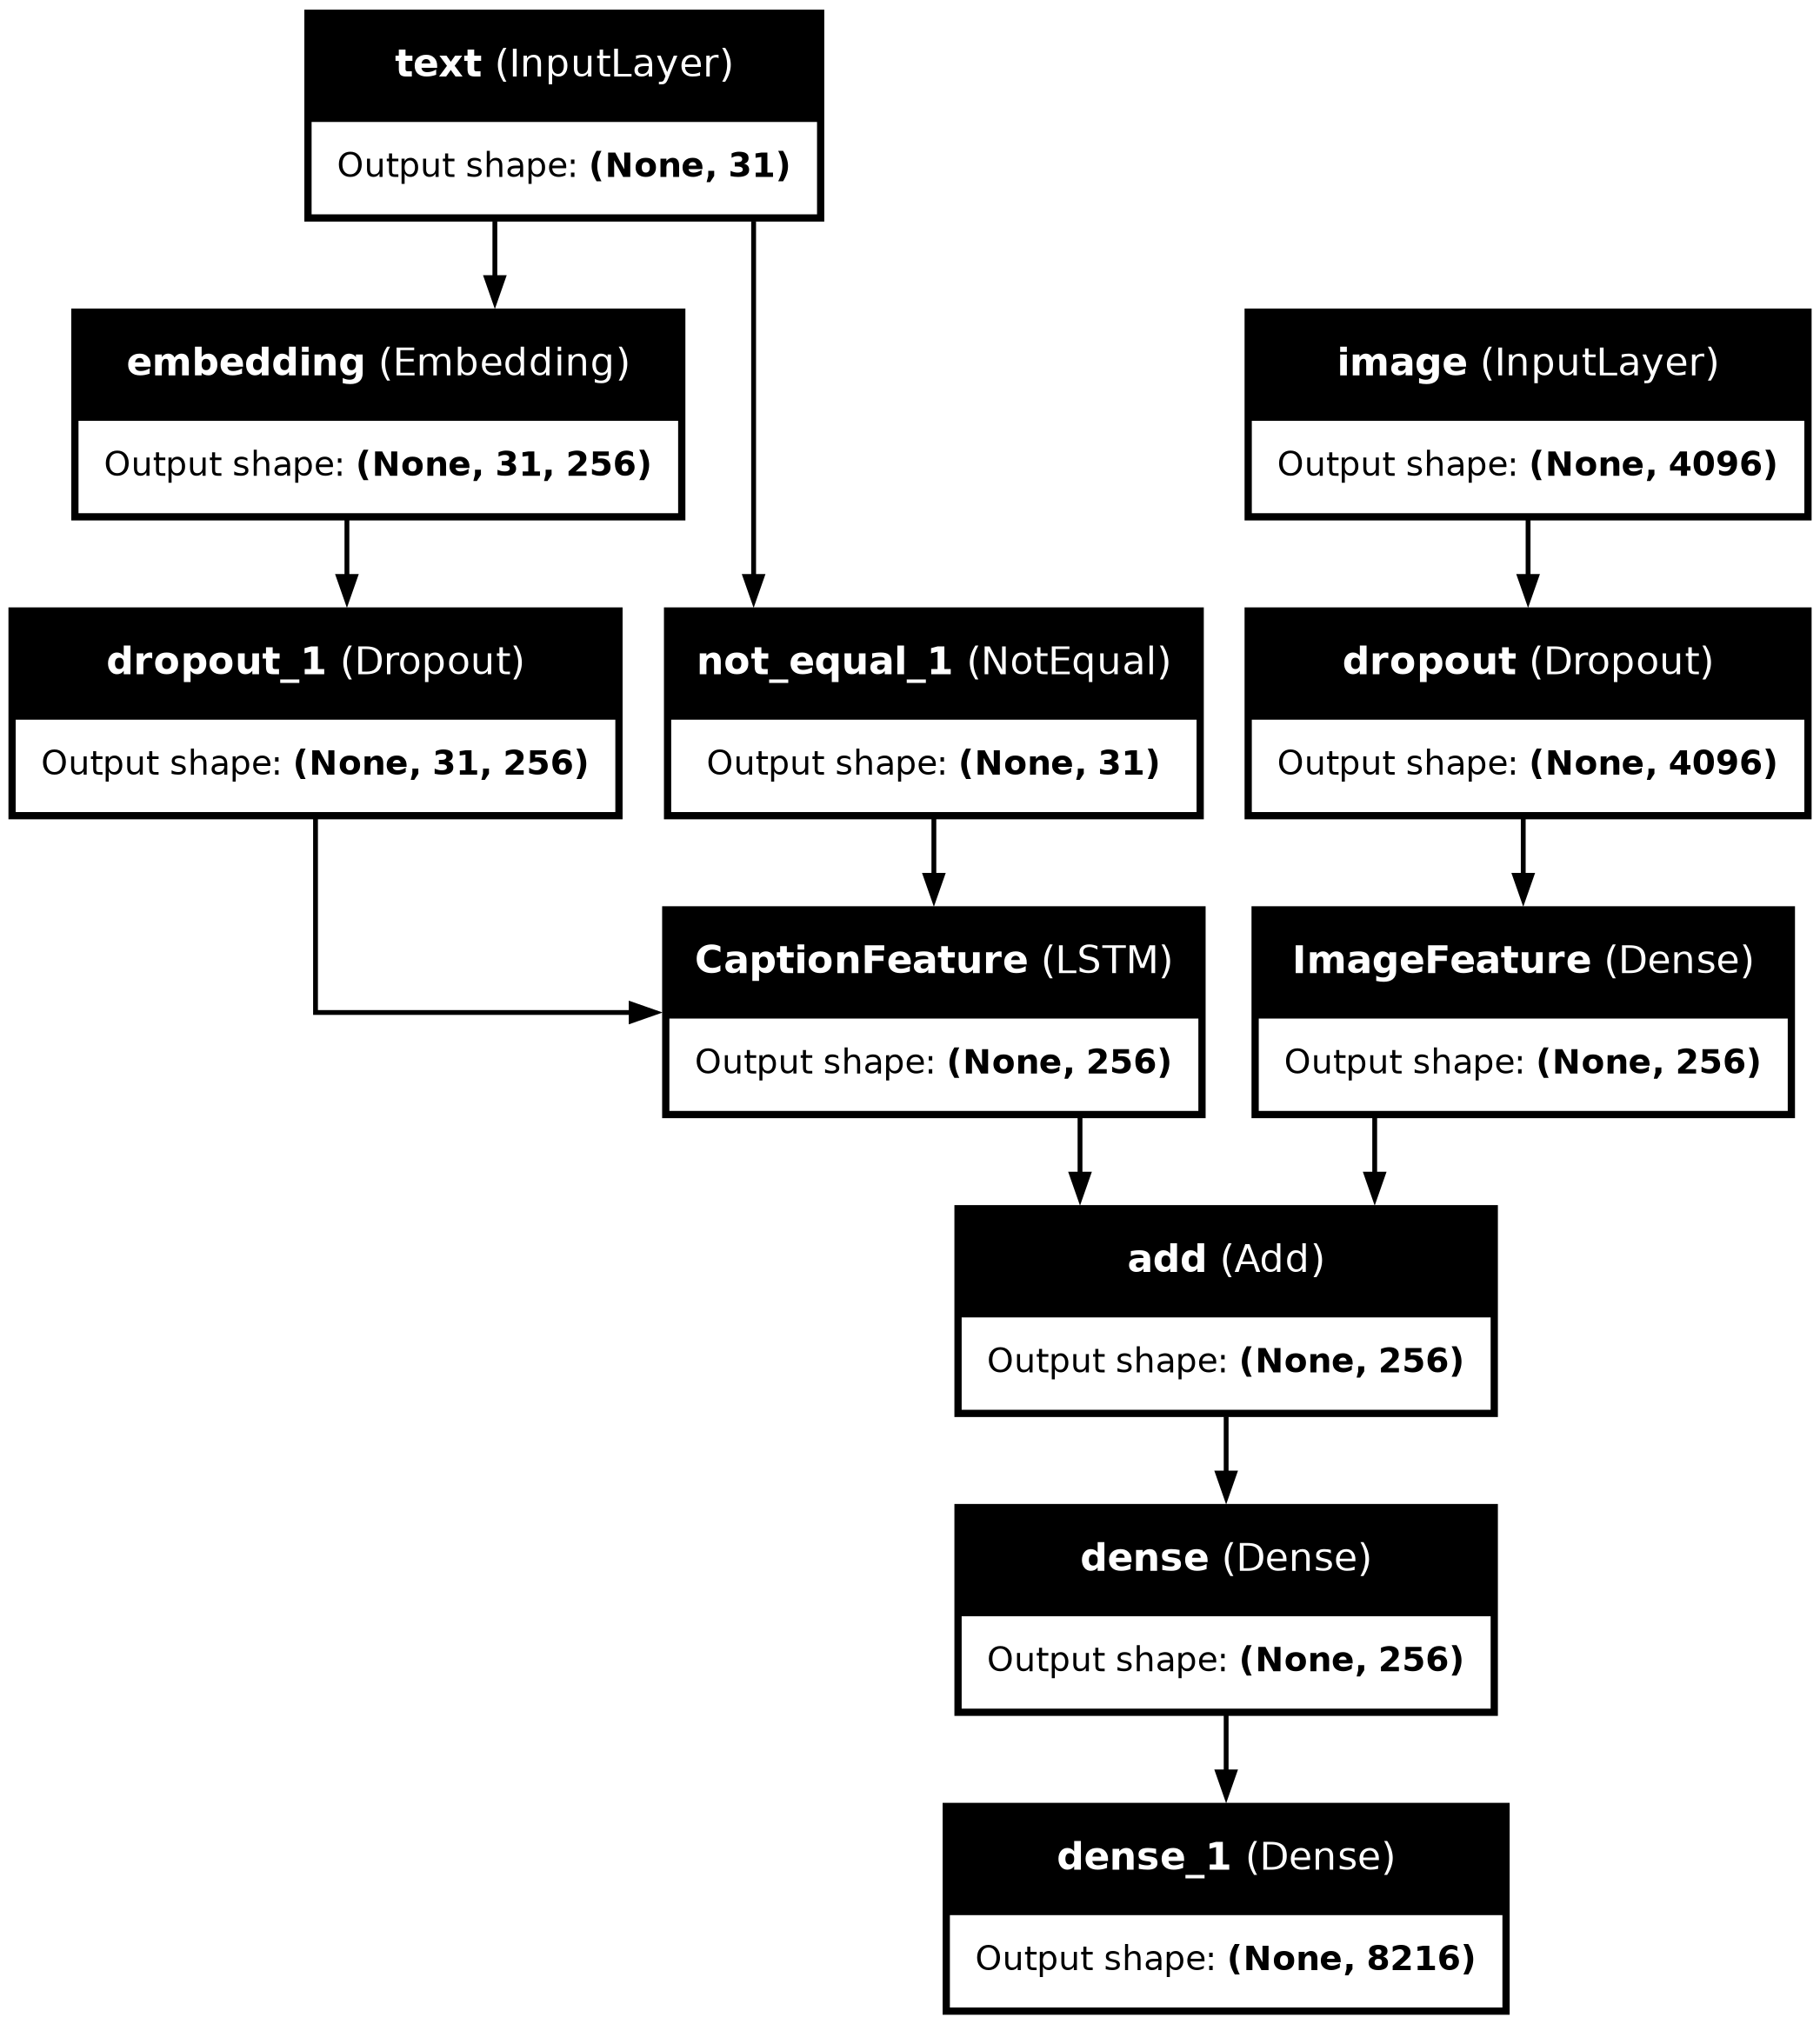

In [27]:
tokenizer, vocab_size, max_len = create_tokenizer(X1_caption_train)
model = create_model(vocab_size, max_len)
model.summary()
plot_model(model, show_shapes=True,show_layer_names=True)

#     tokenizer, max_len, X1_caption_train, X2_feature_train, vocab_size

In [ ]:
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.0001)

In [17]:
epochs = 20
batch_size = 64
steps = len(X1_caption_train) // batch_size
for i in range(epochs):
    generator = data_generator(tokenizer, max_len, X1_caption_train, X2_feature_train, vocab_size,batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 502s 4s/step - loss: 6.1053
113/113 ━━━━━━━━━━━━━━━━━━━━ 481s 4s/step - loss: 4.5374
113/113 ━━━━━━━━━━━━━━━━━━━━ 490s 4s/step - loss: 3.8639
113/113 ━━━━━━━━━━━━━━━━━━━━ 490s 4s/step - loss: 3.5608
113/113 ━━━━━━━━━━━━━━━━━━━━ 487s 4s/step - loss: 3.3503
113/113 ━━━━━━━━━━━━━━━━━━━━ 483s 4s/step - loss: 3.1873
113/113 ━━━━━━━━━━━━━━━━━━━━ 483s 4s/step - loss: 3.0558
113/113 ━━━━━━━━━━━━━━━━━━━━ 480s 4s/step - loss: 2.9523
113/113 ━━━━━━━━━━━━━━━━━━━━ 483s 4s/step - loss: 2.8627
113/113 ━━━━━━━━━━━━━━━━━━━━ 484s 4s/step - loss: 2.7854
113/113 ━━━━━━━━━━━━━━━━━━━━ 482s 4s/step - loss: 2.7233
113/113 ━━━━━━━━━━━━━━━━━━━━ 476s 4s/step - loss: 2.6610
113/113 ━━━━━━━━━━━━━━━━━━━━ 485s 4s/step - loss: 2.6057
113/113 ━━━━━━━━━━━━━━━━━━━━ 489s 4s/step - loss: 2.5540
113/113 ━━━━━━━━━━━━━━━━━━━━ 488s 4s/step - loss: 2.5117
113/113 ━━━━━━━━━━━━━━━━━━━━ 485s 4s/step - loss: 2.4683
113/113 ━━━━━━━━━━━━━━━━━━━━ 483s 4s/step - loss: 2.4322
113/113 ━━━━━━━━━━━━━━━━━━━━ 48

In [18]:
model.save("best_model.keras")
model.save_weights('best_weights.weights.h5')

In [53]:
from tensorflow.keras.models import load_model
model = load_model('/kaggle/input/imagecaptiongeneratormodel/best_model.keras')
model.load_weights('/kaggle/input/imagecaptiongeneratormodel/best_weights.weights.h5')

# Generate captions for the Image

In [32]:
#convert the index into word
def index_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [33]:
def generate_desc(model, photo, tokenizer, max_length):
    #add start tag
    import numpy as np
    in_txt = 'startseq'
    for i in range(max_length):
        #encode input sequence
        sequence = tokenizer.texts_to_sequences([in_txt])[0]
        #pad the sequence
        sequence = pad_sequences([sequence], maxlen = max_length)
        #predict next word
        yhat = model.predict([photo,sequence], verbose = 0)
        yhat = np.argmax(yhat)
        #mapping the integer to word
        word = index_to_word(yhat, tokenizer)
        if word is None:
            break
        in_txt += ' ' + word
        if word == 'endseq':
            break
    return in_txt

In [54]:
##Validate with test data
from nltk.translate.bleu_score import corpus_bleu
def evaluate_test_data(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    for key, desc_list in descriptions.items():
        yhat = generate_desc(model,photos[key], tokenizer, max_length)
        actual_captions = [caption.split() for caption in desc_list]
        actual.append(actual_captions)
        predicted.append(yhat.split())
    #Calculating BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))


In [55]:
evaluate_test_data(model, X1_caption_test, X2_feature_test,tokenizer, max_len)

BLEU-1: 0.532876
BLEU-2: 0.301649
BLEU-3: 0.211798
BLEU-4: 0.102260


# Testing model

In [21]:
def single_image_feature_extractor(image):
    model = VGG16()
    model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

    img = cv2.imread(image)
    try:
        img = cv2.resize(img, (224,224))
        img = img.reshape(1,img.shape[0],img.shape[1],img.shape[2])
        processed_img = preprocess_input(img)
        feature = model.predict(processed_img, verbose = 0)
        return feature
    except:
        print("Error occured in preprocessing")
        return 0

Actual Caption: ['startseq cluster of four brown dogs play in field of brown grass endseq', 'startseq four dogs are together in the field of dry grass endseq', 'startseq four dogs in grassy area endseq', 'startseq four mediumsized dogs wrestle with each other on grass field endseq', 'startseq four small dogs play outside endseq']
Predicted Caption:  startseq two dogs playing together in field of grass endseq


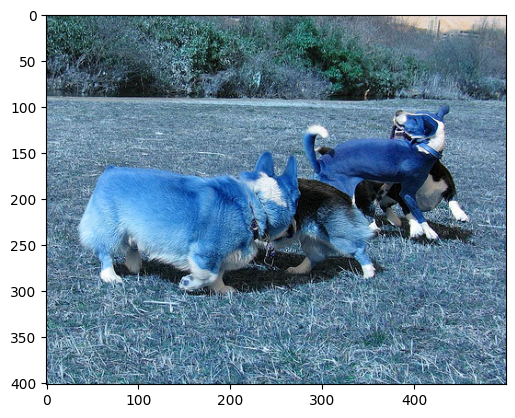

In [39]:
import matplotlib.pyplot as plt
photo_feature = single_image_feature_extractor('/kaggle/input/flickr8k/Images/439492931_a96d590e40.jpg')
plt.imshow(cv2.imread('/kaggle/input/flickr8k/Images/439492931_a96d590e40.jpg'))
print("Actual Caption: "+ str(X1_caption_test['439492931_a96d590e40']))
y_pred = generate_desc(model, photo_feature, tokenizer, max_len)
print("Predicted Caption: ", y_pred)

Actual Caption: ['startseq black and brown dog walks through the snow near building endseq', 'startseq black dog endseq', 'startseq black dog running in the snow by some trees endseq', 'startseq large black and tan dog is running across the snow in wooded area endseq', 'startseq the black and brown dog is running through the snow endseq']
Predicted Caption:  startseq dog is jumping over snow endseq


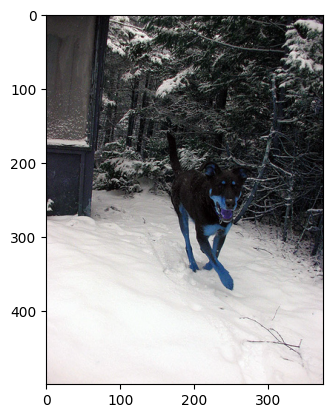

In [40]:
photo_feature = single_image_feature_extractor('/kaggle/input/flickr8k/Images/445655284_c29e6d7323.jpg')
plt.imshow(cv2.imread('/kaggle/input/flickr8k/Images/445655284_c29e6d7323.jpg'))
print("Actual Caption: "+ str(X1_caption_test['445655284_c29e6d7323']))
y_pred = generate_desc(model, photo_feature, tokenizer, max_len)
print("Predicted Caption: ", y_pred)

Actual Caption: ['startseq person in the distance hikes among hoodoos with stars visible in the sky endseq', 'startseq person standing on ridge in the desert endseq', 'startseq interesting rock formations in the desert landscape endseq', 'startseq the night sky in the desert endseq', 'startseq there is person standing mountain that has some interesting shapes endseq']
Predicted Caption:  startseq person is walking through the air on rocky hill endseq


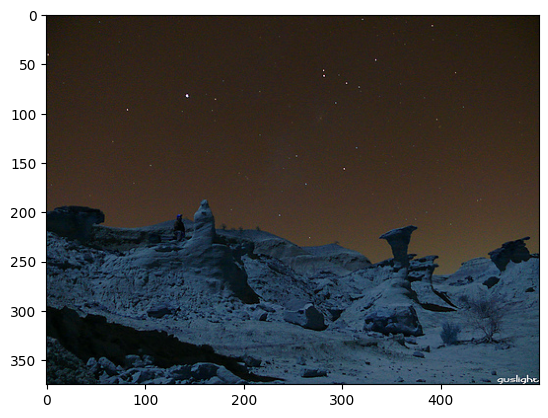

In [41]:
photo_feature = single_image_feature_extractor('/kaggle/input/flickr8k/Images/445148321_9f2f3ac711.jpg')
plt.imshow(cv2.imread('/kaggle/input/flickr8k/Images/445148321_9f2f3ac711.jpg'))
print("Actual Caption: "+ str(X1_caption_test['445148321_9f2f3ac711']))
y_pred = generate_desc(model, photo_feature, tokenizer, max_len)
print("Predicted Caption: ", y_pred)

Predicted Caption:  startseq two dogs are playing in field endseq


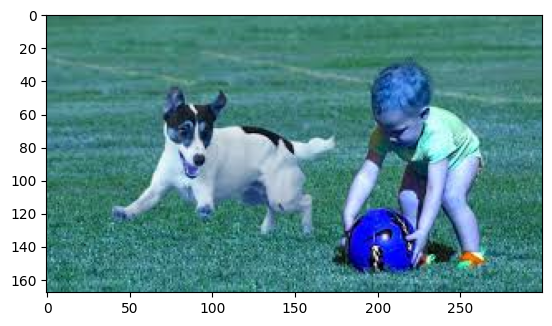

In [47]:
photo_feature = single_image_feature_extractor('/kaggle/input/icg-testdatasets/image1.jpg')
plt.imshow(cv2.imread('/kaggle/input/icg-testdatasets/image1.jpg'))
y_pred = generate_desc(model, photo_feature, tokenizer, max_len)
print("Predicted Caption: ", y_pred)

Predicted Caption:  startseq young girl in pink shirt is jumping on trampoline endseq


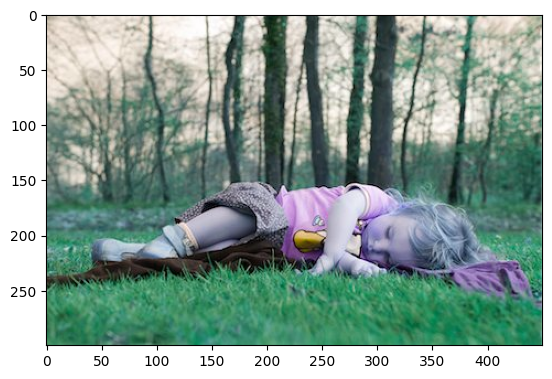

In [51]:
photo_feature = single_image_feature_extractor('/kaggle/input/icg-testdatasets/image2.jpg')
plt.imshow(cv2.imread('/kaggle/input/icg-testdatasets/image2.jpg'))
y_pred = generate_desc(model, photo_feature, tokenizer, max_len)
print("Predicted Caption: ", y_pred)